In [0]:
""" This notebook contains code for computing norms and sharpness values for RMSprop
Results are averaged over 3 random seeds to minimize the variation"""

%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks

In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [0]:
"""We do a grid search over the learning rates. 
We chose learning rate with the lowest validation loss.
Results are averaged over 3 random seeds to minimize the variation."""

validation_losses = []
seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lrs = [3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
    gamma = 0.7
    momentum = 0.9

    use_cuda = torch.cuda.is_available()
    # creating different data loaders
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)
    
    # Grid Search over different learning rates - over validation dataset
    val_losses = []
    for lr in lrs:
        print ("lr:", lr)
        model_copy = copy.deepcopy(model)
        optimizer = optim.RMSprop(model_copy.parameters(), lr=lr, momentum=momentum)
        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

        for epoch in range(1, epochs + 1):
            train_loss = train(model_copy, device, train_loader, optimizer, epoch, batch_size)
            val_loss = test_2(model_copy, device, val_loader, batch_size, val_size)
            # test_loss = test(model_copy, device, test_loader, batch_size)  # one can see on test_loss as well.....
            scheduler.step()
        val_losses.append(val_loss)
    validation_losses.append(val_losses)  

seed::: 12345
54000 6000 10000
lr: 0.03

Test set: Average loss: 2.3014, Accuracy: 638/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)

lr: 0.003

Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test 

In [0]:
print (validation_losses)

#averaging validation losses over different seeds
validation_losses = np.mean(np.array(validation_losses), 0)
print ("averaged_validation losses:: \n", validation_losses)

[[2.3018193929753403, 2.3025848789417998, 1.4456741175753005, 0.97854671516317, 0.1456948902378691], [2.3025848789417998, 2.3025848789417998, 2.3025848789417998, 0.056502143931674194, 0.15001597572514352], [2.3025848789417998, 2.3025848789417998, 2.3025848789417998, 0.4870158291243492, 0.3787290575973531]]
averaged_validation losses:: 
 [2.30232972 2.30258488 2.01694796 0.5073549  0.22481331]


'best lr = 3e-6 in case of RMSprop'

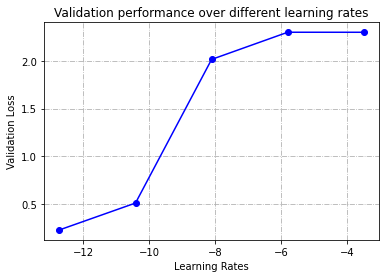

In [0]:
# Learning Rates - ['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'] plotted on log scale
lr_rates = np.log(np.array(lrs))

fig = plt.figure()
plt.plot(lr_rates, validation_losses, color='blue', marker='o') 
plt.xlabel('Learning Rates')
plt.ylabel('Validation Loss')
plt.title("Validation performance over different learning rates")
plt.grid(True, linestyle='-.')
fig.show()   
# plt.legend(['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'], loc='upper right')

"""best lr = 3e-6 in case of RMSprop"""

In [0]:
# Results averaged over 3 different random seeds
avg_train_losses, avg_test_losses, avg_difference_test_train = [], [], []
avg_weight_norms_list, avg_sharpness_list, avg_std_list, avg_mean_list = [], [], [], []

seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lr = 3e-6 # lowest validation loss 
    gamma = 0.7
    momentum = 0.9

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)

    train_losses, test_losses = [], []
    sigmas = [0.001,0.003,0.006,0.009,0.03,0.06,0.09]    
    delta = 1e-2
    mean = 0.0
    weight_norms_list = []
    sharpness_list = []

    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()
    
    avg_train_losses.append(train_losses) 
    avg_test_losses.append(test_losses)

    difference_test_train = np.array(test_losses)  - np.array(train_losses) 
    avg_difference_test_train.append(difference_test_train)

    print ("running for sigmas")
    """run for each sigma"""
    std_list = []
    mean_list = []

    for sigma in sigmas:
        weight_l2_norm = cal_l2_norm(model)
        weight_bound = compute_bound(model, train_size, sigma, weight_l2_norm, delta)  
        weight_norms_list.append(weight_bound)

        #to calculate sharpness, perturb the same model 20 times, then get expected value
        num_times = 20
        p_train_losses = []
        for iterate in range(num_times):
            p_model = copy.deepcopy(model)
            p_model = weight_pertubation(p_model, mean, sigma, device)
            p_train_loss = test_2(p_model, device, train_loader, batch_size, train_size)
            p_train_losses.append(p_train_loss)
        exp_p_error = sum(p_train_losses) / len(p_train_losses)
        std_list.append(np.std(np.array(p_train_losses)))
        mean_list.append(np.mean(np.array(p_train_losses)))

        sharpness = exp_p_error - train_loss
        sharpness_list.append(sharpness)
    
    avg_weight_norms_list.append(weight_norms_list)
    avg_sharpness_list.append(sharpness_list)
    avg_std_list.append(std_list)
    avg_mean_list.append(mean_list)

seed::: 12345
54000 6000 10000

Test set: Average loss: 0.6932, Accuracy: 7525/10000 (75%)


Test set: Average loss: 0.6466, Accuracy: 7638/10000 (76%)


Test set: Average loss: 0.6223, Accuracy: 7674/10000 (77%)


Test set: Average loss: 0.6134, Accuracy: 7706/10000 (77%)


Test set: Average loss: 0.6045, Accuracy: 7718/10000 (77%)


Test set: Average loss: 0.6021, Accuracy: 7724/10000 (77%)


Test set: Average loss: 0.5955, Accuracy: 7726/10000 (77%)


Test set: Average loss: 0.5953, Accuracy: 7732/10000 (77%)


Test set: Average loss: 0.5929, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5930, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5932, Accuracy: 7733/10000 (77%)


Test set: Average loss: 0.5899, Accuracy: 7735/10000 (77%)


Test set: Average loss: 0.5927, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5917, Accuracy: 7735/10000 (77%)

running for sigmas

Test set: Average loss: 0.5809, Accuracy: 42037/54000 (78%)


Test set: Average loss: 0.5810, A

In [0]:
print ("avg_train_losses::\n", avg_train_losses)
print ("avg_test_losses::\n", avg_test_losses)
print ("avg_difference_test_train::\n", avg_difference_test_train)
print ("avg_weight_norms_list::\n", avg_weight_norms_list)
print ("avg_sharpness_list::\n", avg_sharpness_list)
print ("avg_std_list::\n", avg_std_list)

avg_train_losses::
 [[0.8670552924134155, 0.6715083279033408, 0.6354980897599769, 0.6156465685198093, 0.6036139454392461, 0.5959335783081597, 0.5909935224324606, 0.5874978139537488, 0.5853419856508196, 0.583672471997721, 0.5826157523204365, 0.5818005933722049, 0.5813203692895259, 0.5810472483954159], [0.43300891581092965, 0.2268103755110107, 0.18766772654790306, 0.16589207090967073, 0.1527995727691464, 0.14463042052930566, 0.13919387332282926, 0.13567486400517384, 0.13314877496370206, 0.13139232167735768, 0.1302789017884723, 0.12944362622849043, 0.12886045177542202, 0.12847051994601413], [0.4295198499220666, 0.22947994822645074, 0.19054604110736134, 0.16885579194679362, 0.15617784373550478, 0.1476996052542357, 0.1422264360827151, 0.13852177418203432, 0.13595267044053683, 0.13426527145243652, 0.133017151638583, 0.13221764036617573, 0.1316241988850431, 0.13124029561259312]]
avg_test_losses::
 [[0.6931700736853728, 0.6466331979271712, 0.6223080076609447, 0.6133612314606928, 0.604467092046

In [0]:
# Averaging over 3 random seeds
avg_train_losses = np.mean(np.array(avg_train_losses), 0)
avg_test_losses = np.mean(np.array(avg_test_losses), 0)
avg_difference_test_train = np.mean(np.array(avg_difference_test_train), 0)

avg_weight_norms_list = np.mean(np.array(avg_weight_norms_list), 0)
avg_sharpness_list = np.mean(np.array(avg_sharpness_list), 0)
avg_std_list = np.mean(np.array(avg_std_list), 0)
avg_mean_list = np.mean(np.array(avg_mean_list), 0)


print ("avg_train_losses:::\n", avg_train_losses)
print ("avg_test_losses:::\n", avg_test_losses)
print ("average difference list::\n", avg_difference_test_train)
print ("avg_weight_norms_list::\n", avg_weight_norms_list)
print ("avg_sharpness_list::\n", avg_sharpness_list)
print ("avg_std_list::\n", avg_std_list)
print ("avg_mean_list::\n", avg_mean_list)


avg_train_losses:::
 [0.57652802 0.37593288 0.33790395 0.31679814 0.30419712 0.29608787
 0.29080461 0.28723148 0.28481448 0.28311002 0.2819706  0.28115395
 0.28060167 0.28025269]
avg_test_losses:::
 [0.39388574 0.35021758 0.32454344 0.31260465 0.30449171 0.29993519
 0.29551679 0.29354064 0.29184716 0.29131272 0.2903207  0.28916357
 0.28980151 0.28928185]
average difference list::
 [-0.18264228 -0.0257153  -0.01336051 -0.0041935   0.00029459  0.00384732
  0.00471218  0.00630916  0.00703269  0.0082027   0.0083501   0.00800961
  0.00919984  0.00902916]
avg_weight_norms_list::
 [332.32422892 110.77475993  55.38741048  36.92497762  11.07769044
   5.53917027   3.69314106]
avg_sharpness_list::
 [-9.85532483e-05  1.51516006e-03  6.66349150e-03  1.63156179e-02
  4.50531725e-01  4.95540615e+00  1.59675063e+01]
avg_std_list::
 [5.42081049e-05 2.54239183e-04 1.27949598e-03 2.98293809e-03
 1.52601387e-01 1.86666981e+00 5.18276734e+00]
avg_mean_list::
 [ 0.28015413  0.28176785  0.28691618  0.2965683

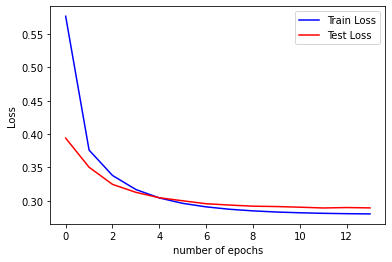

In [0]:
# Plotting training
show_losses(avg_train_losses, avg_test_losses)

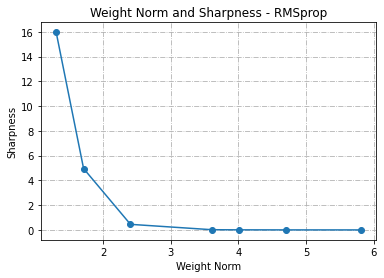

In [0]:
# Plotting Sharpness and Norm term from equation 1 in the report
# Weights are taken on a log scale

plt.plot(np.log(avg_weight_norms_list), avg_sharpness_list, marker='o')
plt.grid(True, linestyle='-.')
plt.title("Weight Norm and Sharpness - RMSprop")
plt.xlabel("Weight Norm")
plt.ylabel("Sharpness")
plt.show()